# Simulated Sky Signal in time domain

In this lesson we will use the TOAST Operator `OpSimPySM` to create timestreams for an instrument given a sky model.

In [1]:
# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

In [2]:
import toast
import healpy as hp
import numpy as np

In [3]:
env = toast.Environment.get()                         
env.set_log_level("DEBUG")

## Scanning strategy

Before being able to scan a map into a timestream we need to define a scanning strategy
and get pointing information for each channel.

We use the same **satellite** scanning used in lesson 2 about scanning strategies,
see the `02_Simulated_Scan_Strategies/simscan_satellite.ipynb` for more details.

In [4]:
focal_plane = fake_focalplane()

In [5]:
focal_plane.keys()

dict_keys(['0A', '0B', '1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', '5A', '5B', '6A', '6B'])

In [6]:
focal_plane["0A"]["fwhm_arcmin"]

30

In [7]:
# Scan parameters

alpha = 50.0      # precession opening angle, degrees
beta = 45.0       # spin opening angle, degrees
p_alpha = 25.0    # precession period, minutes
p_beta = 1.25     # spin period, minutes
samplerate = 0.5  # sample rate, Hz
hwprpm = 5.0      # HWP rotation in RPM
nside = 64        # Healpix NSIDE

# We will use one observation per day, with no gaps in between, and
# run for one year.

obs_samples = int(24 * 3600.0 * samplerate) - 1
nobs = 366

# Slew the precession axis so that it completes one circle

deg_per_day = 360.0 / nobs

In [8]:
from toast.todmap import TODSatellite, slew_precession_axis

In [9]:
detquat = {ch: focal_plane[ch]["quat"] for ch in focal_plane}

In [10]:
# Create distributed data

comm = toast.Comm()
data = toast.Data(comm)

# Append observations

for ob in range(nobs):
    obsname = "{:03d}".format(ob)
    obsfirst = ob * (obs_samples + 1)
    obsstart = 24 * 3600.0
    tod = TODSatellite(
        comm.comm_group, 
        detquat, 
        obs_samples, 
        firstsamp=obsfirst,
        firsttime=obsstart,
        rate=samplerate,
        spinperiod=p_beta,
        spinangle=beta,
        precperiod=p_alpha,
        precangle=alpha,
        coord="E",
        hwprpm=hwprpm
    )
    qprec = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
    slew_precession_axis(
        qprec,
        firstsamp=obsfirst,
        samplerate=samplerate,
        degday=deg_per_day,
    )
    tod.set_prec_axis(qprec=qprec)
    obs = dict()
    obs["tod"] = tod
    data.obs.append(obs)

In [11]:
from toast.todmap import (
    get_submaps_nested,
    OpPointingHpix,
    OpAccumDiag
)
from toast.map import (
    DistPixels
)

# Make a simple pointing matrix

pointing = OpPointingHpix(nside=nside, nest=True, mode="IQU")
pointing.exec(data)

# Compute the locally hit pixels

localpix, localsm, subnpix = get_submaps_nested(data, nside)

# Construct a distributed map to store the hit map

npix = 12 * nside**2

hits = DistPixels(
    comm=data.comm.comm_world,
    size=npix,
    nnz=1,
    dtype=np.int64,
    submap=subnpix,
    local=localsm,
)
hits.data.fill(0)

# Accumulate the hit map locally

build_hits = OpAccumDiag(hits=hits)
build_hits.exec(data)

# Reduce the map across processes (a No-op in this case)

hits.allreduce()

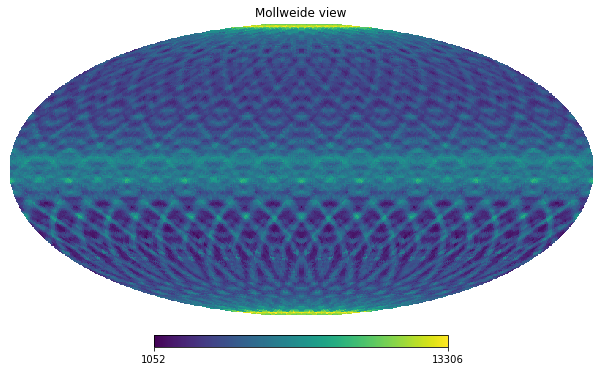

In [12]:
%matplotlib inline
hp.mollview(hits.data.flatten(), nest=True)

## Define PySM parameters and instrument bandpasses

Then we define the sky model parameters, choosing the desired set of `PySM` models and then we specify the band center and the bandwidth for a top-hat bandpass.
Currently top-hat bandpasses are the only type supported by the operator, in the future we will implement arbitrary bandpasses.

Then bandpass parameters can be added directly to the `focal_plane` dictionary:

In [13]:
for ch in focal_plane:
    focal_plane[ch]["bandcenter_ghz"] = 70                                                                                              
    focal_plane[ch]["bandwidth_ghz"] = 10
    focal_plane[ch]["fwhm"] = 60*2

In [14]:
pysm_sky_config = ["s1", "f1", "a1", "d1"]  #syncrotron free free a&e and dust components of the sky

## Run the OpSimPySM operator

The `OpSimPySM` operator:
  * Creates top-hat bandpasses arrays (frequency axis and weights) as expected by `PySM`
  * Loops by channel and for each:
      * Creates a `PySMSky` object just with 1 channel at a time
      * Executes `PySMSky` to evaluate the sky models and bandpass-integrate
      * Calls `PySM` to perform distributed smoothing with `libsharp`
      * Gathers the map on the first MPI process
      * Applies coordinate transformation if necessary (not currently implemented in `libsharp`)
      * Use the `DistMap` object to communicate to each process the part of the sky they observe 
      * Calls `OpSimScan` to rescan the map to a timeline

In [15]:
from toast.todmap import OpSimPySM
OpSimPySM?

Init signature:
OpSimPySM(
    comm=None,
    out='signal',
    pysm_model=None,
    pysm_precomputed_cmb_K_CMB=None,
    pysm_component_objects=None,
    focalplanes=None,
    nside=None,
    subnpix=None,
    localsm=None,
    apply_beam=False,
    nest=True,
    units='K_CMB',
    debug=False,
    coord='G',
    map_dist=None,
)
Docstring:     
Operator which generates a bandpass integrated and smoothed sky signal with PySM 3

This operator:
* Extracts band centers,  bandwidths and fwhm from the defined focalplane
* Creates a `PySMSky` object
* Runs `PySMSky` and gets distributed maps
* Performs distributed smoothing with libsharp facilities provided by PySM 3
* Communicates the distributed map to the first process
* Communicates to each of the processes their local pixels
* Rescans the pixels to a timeline

For PySM related arguments, see the PySMSky docstring

Args:
    comm (mpi4py.MPI.Comm): MPI communicator
    out (str): accumulate data to the cache with name <out>_<detector>.

In [16]:
opsim_pysm = OpSimPySM(
    comm=None,
    pysm_model=pysm_sky_config,
    nside=nside,
    apply_beam=True,
    debug=True,
    focalplanes=[focal_plane],
    subnpix=subnpix,
    localsm=localsm
)

In [17]:
opsim_pysm.exec(data)

### Plot output timelines

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
tod = data.obs[0]['tod']

In [20]:
pix = tod.cache.reference("pixels_0A")

In [21]:
import toast.qarray as qa
theta, phi, pa = qa.to_angles(tod.read_pntg(detector="0A"))
#read_pntg gives quaternials and to angles gives theta the colatitude (0 = NP, 180 = SP) and phi and pa

In [22]:
pix

array([31066, 29622, 29481, ..., 23609, 23762, 23986], dtype=int64)

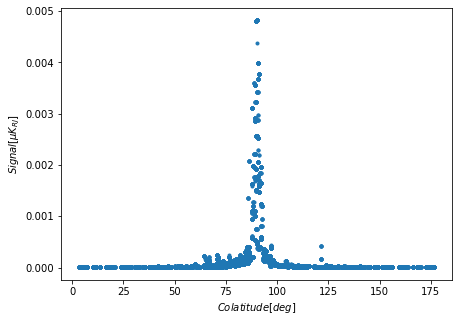

In [23]:
num = 10000
plt.figure(figsize=(7, 5))
plt.plot(np.degrees(theta[:num]), tod.cache.reference("signal_0A")[:num], ".")
plt.xlabel("$Colatitude [deg]$")
plt.ylabel("$Signal [ \mu K_{RJ} ]$");

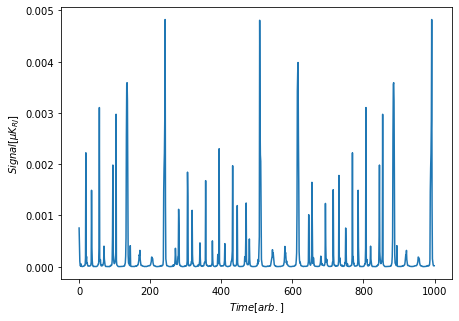

In [27]:
num = 1000
plt.figure(figsize=(7, 5))
plt.plot(tod.cache.reference("signal_0A")[:num], "-")
plt.xlabel("$Time [arb.]$")
plt.ylabel("$Signal [ \mu K_{RJ} ]$");
#can see the signal as the pixel goes over the galaxy, another view of the same data

### Bin the output to a map

In [28]:
from numba import njit #just in time compiler for python can use this sometimes to avoid writting C++

In [29]:
@njit  #causes numba to compile this function so that it runs faster
def just_make_me_a_map(output_map, signals):
    """Temperature only binner
    
    Bins a list of (pix, signal) tuples into an output map,
    it does not support polarization, so it just averages it out.
    
    Parameters
    ----------
    output_map : np.array
        already zeroed output map
    signals : numba.typed.List of (np.array[int64] pix, np.array[np.double] signal)
    
    Returns
    -------
    hits : np.array[np.int64]
        hitmap
    """
    hits = np.zeros(len(output_map), dtype=np.int64)
    for pix, signal in signals:
        for p,s in zip(pix, signal):
            output_map[p] += s
            hits[p] += 1
    output_map[hits != 0] /= hits[hits != 0]
    return hits

In [30]:
from numba.typed import List

signals = List()
for obs in data.obs:
    for ch in focal_plane:
        signals.append((obs["tod"].cache.reference("pixels_%s" % ch), obs["tod"].cache.reference("signal_%s" % ch)))

In [31]:
output_map = np.zeros(npix, dtype=np.double)
h = just_make_me_a_map(output_map, signals)

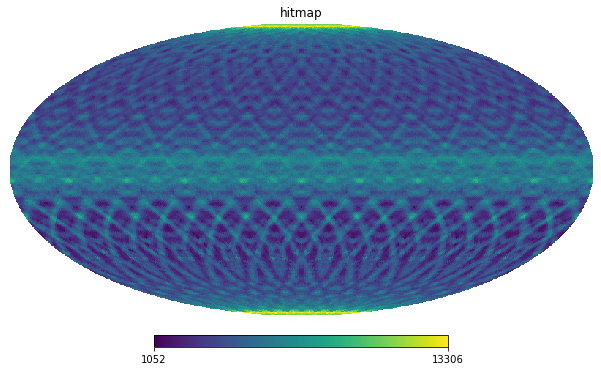

In [32]:
hp.mollview(h, title="hitmap", nest=True)

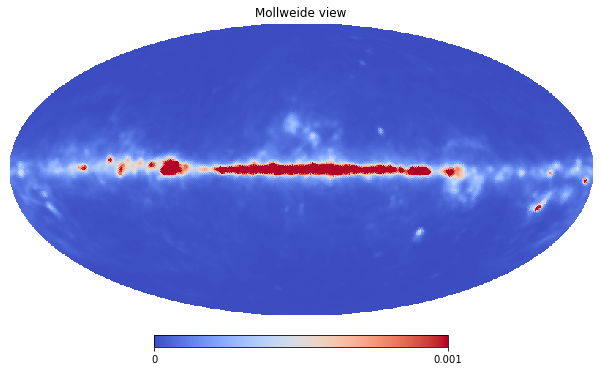

In [33]:
hp.mollview(output_map, nest=True, min=0, max=1e-3, cmap="coolwarm")  #making a map from our focal plane with 2 deg beams

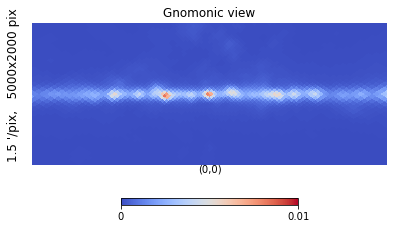

In [34]:
hp.gnomview(output_map, rot=(0,0), xsize=5000, ysize=2000, cmap="coolwarm", nest=True, min=0, max=1e-2)

### Custom sky components

* `pysm_component_objects`: pass custom PySM component objects, see for example the [WebSkyCIB](https://so-pysm-models.readthedocs.io/en/latest/api/so_pysm_models.WebSkyCIB.html#so_pysm_models.WebSkyCIB) model in the [so_pysm_models](https://github.com/simonsobs/so_pysm_models) repository, it provides a Cosmic Infrared Background computed from 